# Reinforcement Learning

# 6. Bandit Algorithms

This notebook presents **multi-armed bandit** algorithms.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from model import Environment
from agent import Agent

## Multi-Armed Bandit

Multi-armed bandits are single-state models with random rewards.

In [3]:
class MAB(Environment):
    """Multi-Armed Bandit environnement.
    
    Parameters
    ----------
    distribution: string
        Reward distribution (Bernoulli, Uniform or Gaussian)
    params: list
        List of parameters (one per action)
        Example for Bernoulli (mean): [0.4, 0.5, 0.6]
        Example for Uniform (low, high): [(-1, 1), (0, 1), (-1, 2)]
        Example for Gaussian (mean, variance): [(0, 1), (1, 2), (-1, 1)]
    """

    def __init__(self, distribution='bernoulli', params=[0.4, 0.6]):        
        if type(distribution) != str:
            raise ValueError("The parameter 'distribution' must be a string: either 'bernoulli', 'uniform' or 'gaussian'.")
        self.distribution = distribution.lower()
        self.params = params
         
    @staticmethod
    def get_states():
        """Single state."""
        return [None]
    
    def get_actions(self):
        """One action per arm."""
        actions = [action for action, _ in enumerate(self.params)]
        return actions
    
    def get_reward(self, action):
        """Random reward. The parameter depends on the action."""
        if self.distribution == 'bernoulli':
            return np.random.random() < self.params[action]
        if self.distribution == 'uniform':
            low, high = self.params[action]
            return np.random.uniform(low, high)
        if self.distribution in ['gaussian', 'normal']:
            mean, std = self.params[action]
            return np.random.normal(mean, std)
        raise ValueError('Unknown distribution.')
        
    def get_model(self):
        raise ValueError('Not available.')
        
    def step(self, action):
        stop = False
        reward = self.get_reward(action)
        return reward, stop

In [4]:
class Bandit(Agent):
    """Bandit algorithm with random policy. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    init_value : float
        Initial value of the action-value function.
    init_count : int
        Initial count of the action-count function.
    """
    
    def __init__(self, model, init_value=0, init_count=0):
        if not isinstance(model, MAB):
            raise ValueError('The model must be a multi-armed bandit.')
        self.model = model
        self.policy = self.random_policy
        actions = model.get_actions()
        self.values = len(actions) * [init_value]
        self.counts = len(actions) * [init_count]

    def get_actions(self, state=None):
        """Get all possible actions."""
        return self.model.get_actions()
    
    def get_episode(self, horizon=100):
        """Get the rewards for an episode and update the values."""
        state = None
        rewards = []
        for t in range(horizon):
            action = self.get_action(state)
            reward, _ = self.model.step(action)
            rewards.append(reward)
            self.counts[action] += 1
            diff = reward - self.values[action]
            # update by temporal difference
            self.values[action] += diff / self.counts[action]
        return rewards    

In [5]:
model = MAB()

In [6]:
model.distribution

'bernoulli'

In [7]:
model.params

[0.4, 0.6]

In [8]:
agent = Bandit(model)

In [9]:
agent.get_actions()

[0, 1]

In [10]:
rewards = agent.get_episode(horizon=100)

In [11]:
np.mean(rewards)

0.61

In [12]:
agent.values

[0.6, 0.6181818181818179]

In [13]:
agent.counts

[45, 55]

## The $\varepsilon$-greedy policy

In [14]:
class Greedy(Bandit):
    """Bandit algorithm with epsilon-greedy policy. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    epsilon : float in [0, 1]
        Exploration rate.
    init_value : float
        Initial value of the action-value function.
    init_count : int
        Initial count of the action-count function.
    """
    
    def __init__(self, model, epsilon=0.1, init_value=0, init_count=0):
        super(Greedy, self).__init__(model, init_value, init_count) 
        self.epsilon = epsilon

    def get_action(self, state=None):
        """Get action with eps-greedy policy."""
        actions = self.get_actions()
        if np.random.random() > self.epsilon:
            # select the best action(s) with probability 1 - epsilon
            values = np.array(self.values)
            actions = np.flatnonzero(values==np.max(values))
        return np.random.choice(actions)


In [15]:
agent = Greedy(model)

In [16]:
rewards = agent.get_episode(horizon=100)

In [17]:
np.mean(rewards)

0.58

In [18]:
agent.values

[0.4444444444444444, 0.5934065934065935]

In [19]:
agent.counts

[9, 91]

## To do 

* Compute the expected **gain** for $\varepsilon = 0.2$ and check your result by simulation.<br>**Hint:** You might adapt the time horizon.
* Observe the phenomenon of **optimism in face of incertainty** when $\varepsilon = 0$.<br>**Hint:** You might adapt the parameters ``init_value`` and ``init_count``.

In [24]:
time_horizon = 1000
num_simulations = 100

epsilon = 0.2

total_gains = []

for _ in range(num_simulations):
    bandit = Greedy(model=model, epsilon=epsilon)
    gain = sum(bandit.get_episode(horizon=time_horizon)) 

expected_gain = np.mean(total_gains)
print(f"Expected Gain for epsilon={epsilon}: {expected_gain}")

Expected Gain for epsilon=0.2: 575.33


In [25]:
epsilon = 0  # No exploration
optimistic_init_value = 1.0  # Optimistic initial estimate
init_count = 0

total_gains_optimistic = []

for _ in range(num_simulations):
    bandit = Greedy(model=model, epsilon=epsilon, init_value=optimistic_init_value, init_count=init_count)
    gain = sum(bandit.get_episode(horizon=time_horizon))
    total_gains_optimistic.append(gain)

expected_gain_optimistic = np.mean(total_gains_optimistic)
print(f"Expected Gain with optimism (epsilon=0): {expected_gain_optimistic}")


Expected Gain with optimism (epsilon=0): 546.28


## The UCB policy

We now consider the UCB (Upper Confidence Bound) policy.

## To do

* Complete and test the agent ``UCB`` below.
* Plot the **regret** with respect to the time horizon, and compare with the $\varepsilon$-greedy policy for different values of $\varepsilon$.
* Repeat this experiment for the other models (uniform and Gaussian).<br> Interpret the results.
* Test the impact of the number of actions.

In [31]:
class UCB(Bandit):
    """Bandit algorithm with UCB policy. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    const : float in [0, 1]
        Multiplicative constant for the UCB bonus.
    init_value : float
        Initial value of the action-value function.
    init_count : int
        Initial count of the action-count function.
    """
    
    def __init__(self, model, const=1, init_value=0, init_count=0):
        super(UCB, self).__init__(model, init_value, init_count) 
        self.const = const

    def get_action(self, state=None):
        """Get action with UCB policy."""
        t = sum(self.counts) + 1  # Total steps so far
        actions = self.get_actions()
        values = np.array(self.values)
        counts = np.array(self.counts)

        # Calculate the UCB for each action
        ucb_values = values + self.const * np.sqrt(np.log(t) / (counts + 1e-5))  # Avoid division by zero
        return np.random.choice(np.flatnonzero(ucb_values == np.max(ucb_values)))

In [32]:
agent = UCB(model)

In [33]:
total_gains_optimistic = []

for _ in range(num_simulations):
    bandit = UCB(model)
    gain = sum(bandit.get_episode(horizon=time_horizon))
    total_gains_optimistic.append(gain)

expected_gain_optimistic = np.mean(total_gains_optimistic)
print(f"Expected Gain with optimism (epsilon=0): {expected_gain_optimistic}")

Expected Gain with optimism (epsilon=0): 581.01


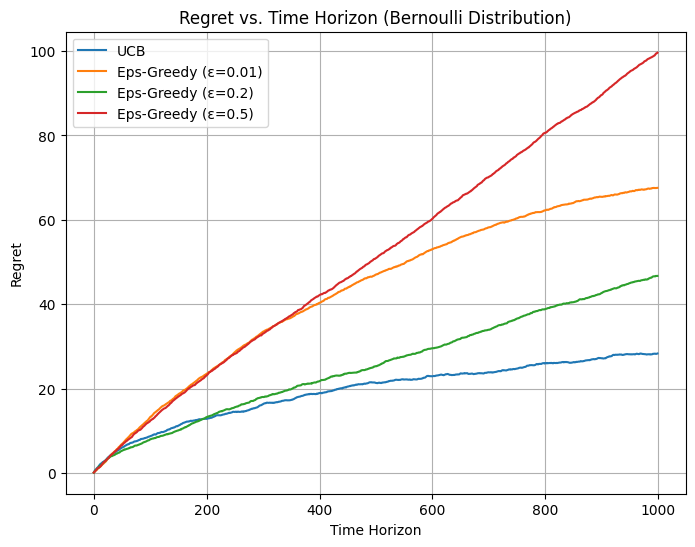

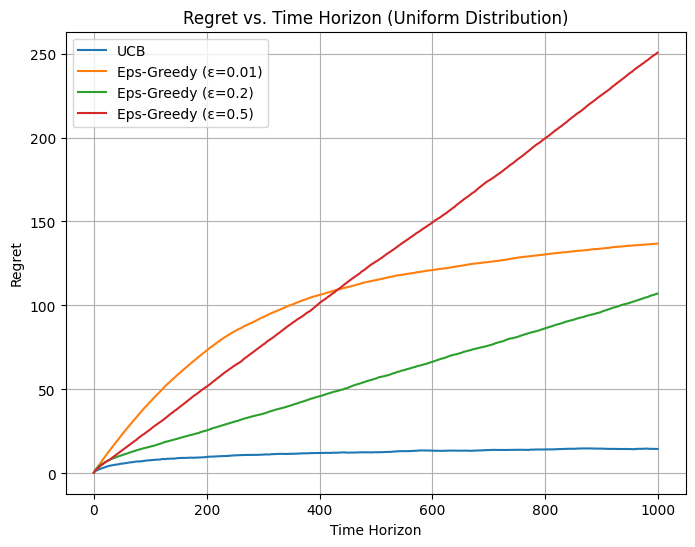

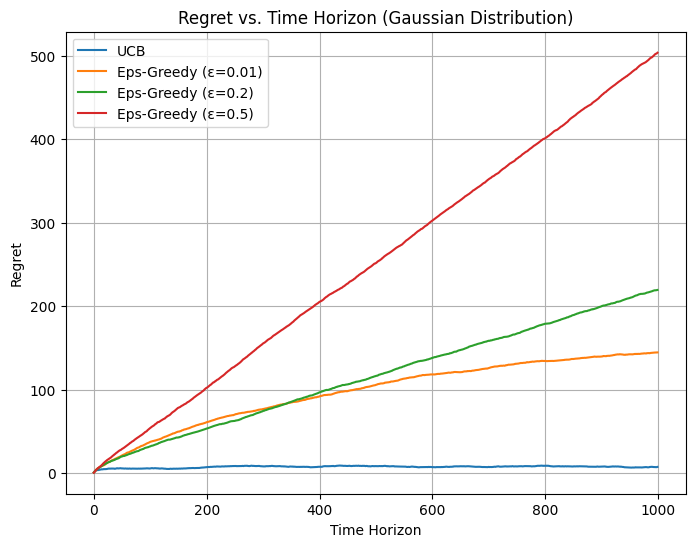

In [51]:
def calculate_regret(algorithm, model, horizon=1000, num_runs=100, **kwargs):
    actions = model.get_actions()
    optimal_action = np.argmax(
        [np.mean([model.get_reward(a) for _ in range(1000)]) for a in actions]
    )
    regrets = np.zeros(horizon)

    for _ in range(num_runs):
        algo_instance = algorithm(model, **kwargs)
        rewards = algo_instance.get_episode(horizon)
        cumulative_rewards = np.cumsum(rewards)
        optimal_rewards = np.arange(1, horizon + 1) * np.mean(
            [model.get_reward(optimal_action) for _ in range(1000)]
        )
        regrets += optimal_rewards - cumulative_rewards

    return regrets / num_runs

def plot_regret_separate(models, horizon=1000, num_runs=100):
    for model_name, model in models.items():
        plt.figure(figsize=(8, 6))
        
        # UCB Policy
        ucb_regret = calculate_regret(UCB, model, horizon, num_runs, const=1)
        plt.plot(ucb_regret, label="UCB")

        # Epsilon-Greedy for various epsilons
        for epsilon in [0.01, 0.2, 0.5]:
            greedy_regret = calculate_regret(Greedy, model, horizon, num_runs, epsilon=epsilon)
            plt.plot(greedy_regret, label=f"Eps-Greedy (ε={epsilon})")

        plt.xlabel("Time Horizon")
        plt.ylabel("Regret")
        plt.title(f"Regret vs. Time Horizon ({model_name} Distribution)")
        plt.legend()
        plt.grid()
        plt.show()


models = {
    "Bernoulli": MAB(distribution="bernoulli", params=[0.4, 0.6, 0.8]),
    "Uniform": MAB(distribution="uniform", params=[(0, 1), (1, 2), (0.5, 1.5)]),
    "Gaussian": MAB(distribution="gaussian", params=[(0, 1), (1, 2), (2, 1)]),
}

plot_regret_separate(models)


From the graphs, we see that UCB consistently outperforms epsilon-greedy by adaptively balancing exploration and exploitation using its upper confidence bound formula. In contrast, epsilon-greedy depends heavily on the parameter epsilon: smaller values perform better due to reduced exploration, while larger epsilon lead to excessive exploration and higher regret, especially in Uniform and Gaussian distributions.

In the Bernoulli distribution, UCB shows only a slight advantage as epsilon-greedy can handle simpler rewards well with a properly tuned epsilon. However, in Uniform and Gaussian distributions, where rewards have higher variance, UCB significantly outperforms epsilon-greedy, which struggles to balance exploration and exploitation effectively.

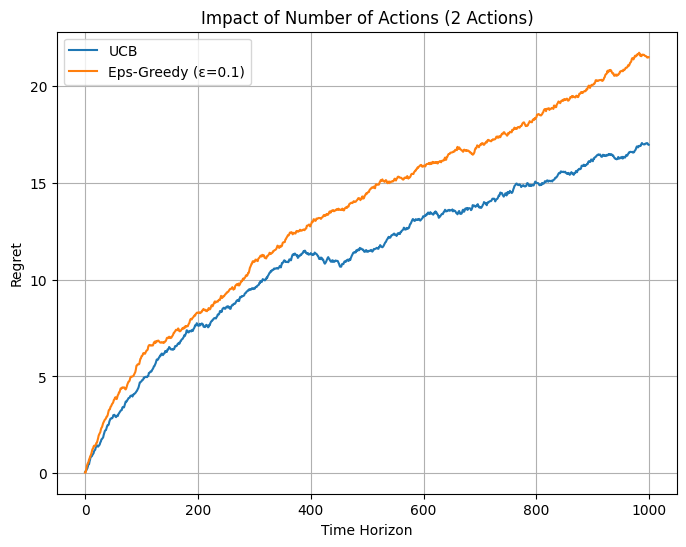

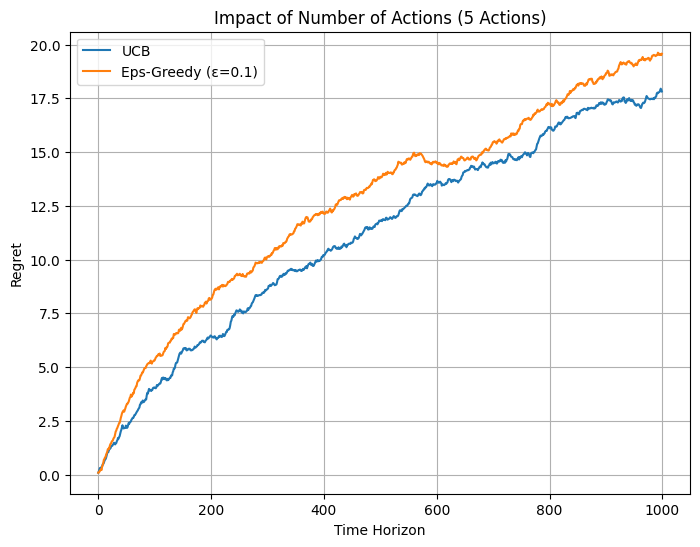

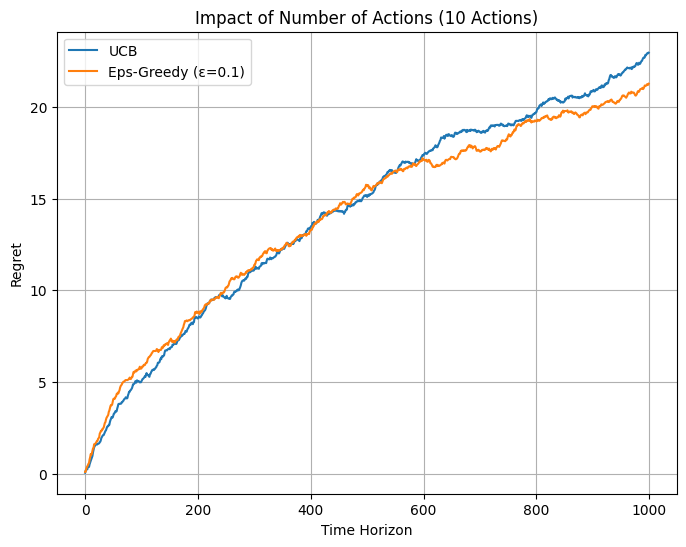

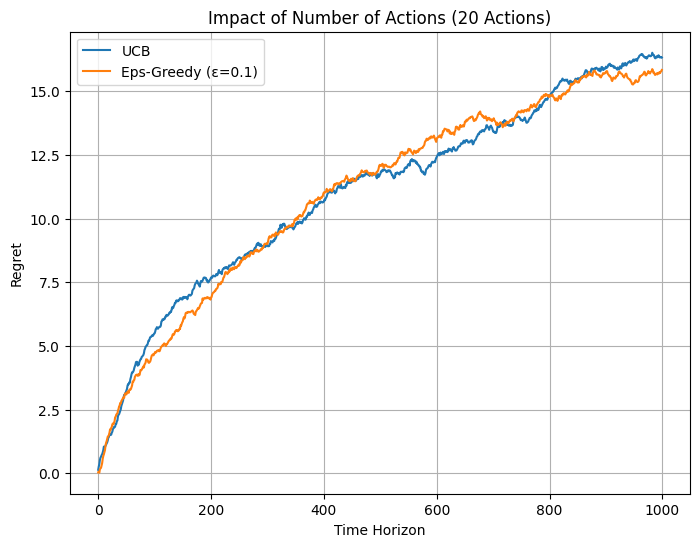

In [ ]:
def test_num_actions_separate(horizon=1000, num_runs=100):
    num_actions_list = [2, 5, 10, 20]

    for num_actions in num_actions_list:
        plt.figure(figsize=(8, 6))
        
        ucb_regret = calculate_regret(UCB, model, horizon, num_runs, const=1)
        plt.plot(ucb_regret, label="UCB")

        greedy_regret = calculate_regret(Greedy, model, horizon, num_runs, epsilon=0.1)
        plt.plot(greedy_regret, label="Eps-Greedy (ε=0.1)")

        plt.xlabel("Time Horizon")
        plt.ylabel("Regret")
        plt.title(f"Impact of Number of Actions ({num_actions} Actions)")
        plt.legend()
        plt.grid()
        plt.show()

test_num_actions_separate()

For 2 and 5 actions, UCB consistently maintains a lower regret compared to epsilon-greedy, demonstrating its efficiency in balancing exploration and exploitation. However, as the number of actions increases to 10 and 20, the gap between the two algorithms narrows, and epsilon-greedy begins to perform comparably, even slightly better in some cases. This indicates that epsilon-greedy benefits from a simpler exploration strategy when the action space grows, whereas UCB's performance can fluctuate slightly with increased complexity.

## Thompson sampling

Finally, we consider Thompson Sampling, where the mean rewards are considered as random and sampled according to the posterior distribution (Bayesian algorithm).

## To do

* Complete and test the agent ``TS`` below.
* Plot the **regret** with respect to the time horizon, and compare with the UCB policy for different models.
* Which algorithm is the more efficient?<br> Comment your results.

In [46]:
class TS(Bandit):
    """Bandit algorithm with Thompson sampling. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    """
    
    def __init__(self, model):
        super(TS, self).__init__(model) 
        self.distribution = model.distribution
            
    def get_action(self, state=None):
        """Get action with TS policy."""
        values = np.array(self.values)
        counts = np.array(self.counts)
        if self.distribution == 'bernoulli':
            # to be modified
            alpha = values * counts + 1
            beta = (1 - values) * counts + 1
            samples = np.random.beta(alpha, beta)
        else:
            # to be modified
            mu = values
            sigma = 1 / (counts + 1)  # Assuming known variance
            samples = np.random.normal(mu, sigma)
        return np.argmax(samples)


In [47]:
agent = TS(model)

In [48]:
total_gains_optimistic = []

for _ in range(num_simulations):
    bandit = TS(model)
    gain = sum(bandit.get_episode(horizon=time_horizon))
    total_gains_optimistic.append(gain)

expected_gain_optimistic = np.mean(total_gains_optimistic)
print(f"Expected Gain: {expected_gain_optimistic}")

Expected Gain with optimism (epsilon=0): 592.2


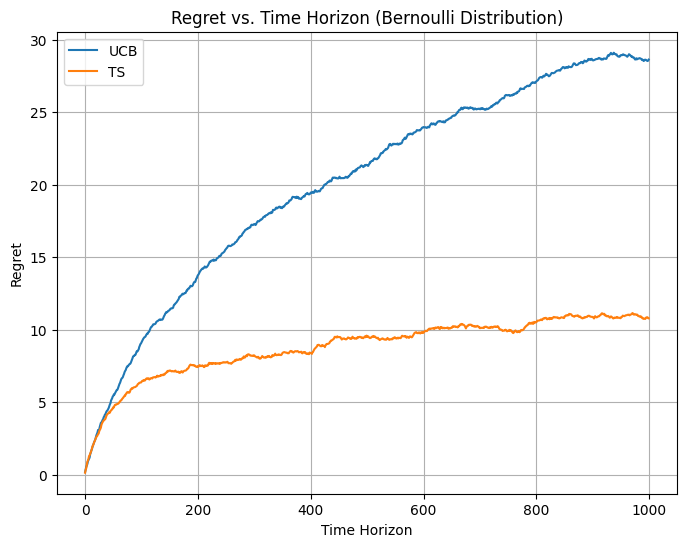

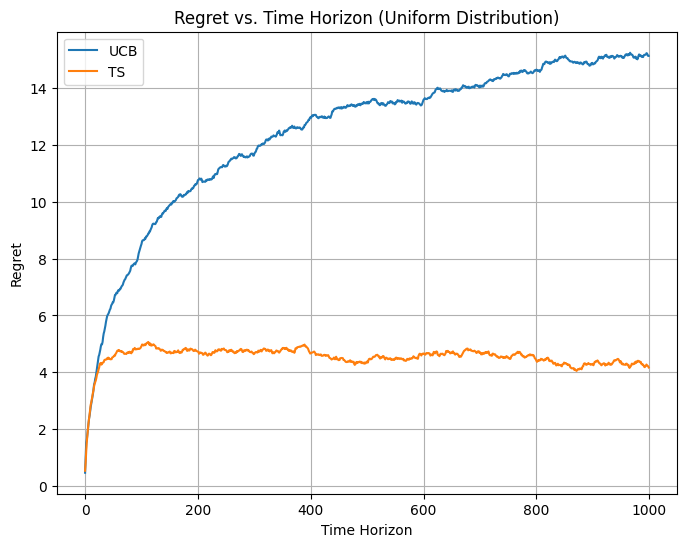

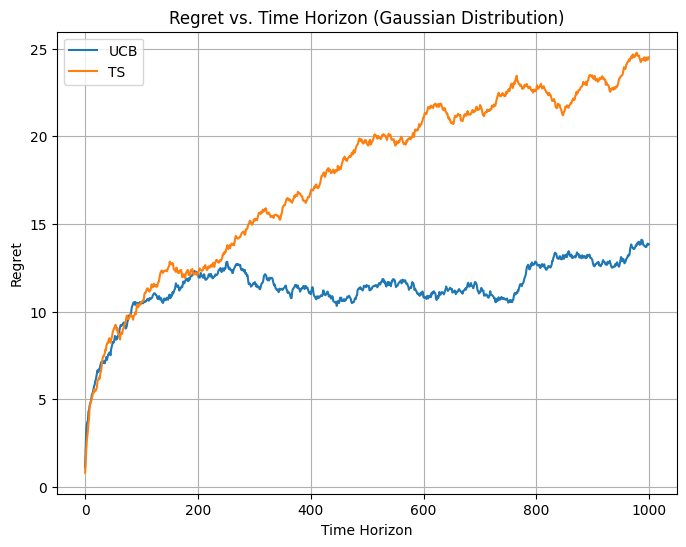

In [53]:
def plot_regret_separate(models, horizon=1000, num_runs=100):
    for model_name, model in models.items():
        plt.figure(figsize=(8, 6))
        
        # UCB Policy
        ucb_regret = calculate_regret(UCB, model, horizon, num_runs)
        plt.plot(ucb_regret, label="UCB")

        # Epsilon-Greedy for various epsilons
        greedy_regret = calculate_regret(TS, model, horizon, num_runs)
        plt.plot(greedy_regret, label=f"TS")

        plt.xlabel("Time Horizon")
        plt.ylabel("Regret")
        plt.title(f"Regret vs. Time Horizon ({model_name} Distribution)")
        plt.legend()
        plt.grid()
        plt.show()


models = {
    "Bernoulli": MAB(distribution="bernoulli", params=[0.4, 0.6, 0.8]),
    "Uniform": MAB(distribution="uniform", params=[(0, 1), (1, 2), (0.5, 1.5)]),
    "Gaussian": MAB(distribution="gaussian", params=[(0, 1), (1, 2), (2, 1)]),
}

plot_regret_separate(models)

From the graphs, we observe that Thompson Sampling (TS) consistently outperforms UCB in the Bernoulli and Uniform distributions by maintaining a significantly lower regret.  However, in the Gaussian distribution, UCB demonstrates better performance as it handles the higher variance of rewards more effectively than TS. These results highlight the strengths of TS in simpler reward structures and UCB in more complex, high-variance environments.